In [144]:
# Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score  #  Scoring Measurement

import pandas as pd
import RandomForestTools  # Some of my own tools
%matplotlib inline

In [166]:
# Read the data
X = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")
test_passId = X_test["PassengerId"]
y = X.pop("Survived")  # The measurement we want to look at

In [146]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Since the age doesn't have 891 measurements, we need to do something about the missing ages.  

In [147]:
# For now, fill in the missing Age data with the mean
#X["Age"].fillna(X["Age"].mean(), inplace=True)

# Try #2 was to replace with a odd number to mark missing ages as special
X["Age"].fillna(-100.0, inplace=True)
X_test["Age"].fillna(-100.0, inplace=True)
X_test["Fare"].fillna(X_test["Fare"].mean(), inplace=True)

#Try #3 was removing them all together
#y = y[X["Age"].isnull() == 0]
#X = X[X["Age"].isnull() == 0]

In [148]:
# For now, just build the model based on numeric values
numeric_values = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_values].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22,1,0,7.2500
1,2,1,38,1,0,71.2833
2,3,3,26,0,0,7.9250
3,4,1,35,1,0,53.1000
4,5,3,35,0,0,8.0500


Pclass is definitely a categorical variable, but let's leave it in for now (since it can be treated numerically).  PassengerID is probably not worth using in a fit (since it's probably a random number).  But maybe a randomly distributed number actually does say something interesting if the random assignment isn't truely random.

In [149]:
# First model
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=69)
model.fit(X[numeric_values], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=69,
           verbose=0, warm_start=False)

In [150]:
print("AOC: ", roc_auc_score(y, model.oob_prediction_))

AOC:  0.741478392399


In [151]:
RandomForestTools.describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"de Mulder, Mr. Theodore",male,347082,G6,S
freq,1,577,7,4,644


In [152]:
# Drop some statistics that are probably not useful (like Name, ticket, and PassengerId)
X.drop(["Name", "PassengerId", "Ticket", 'Cabin'], axis=1, inplace=True)
X_test.drop(["Name", "PassengerId", "Ticket", 'Cabin'], axis=1, inplace=True)

In [153]:
categorical_variables = ["Sex","Embarked"]
X = RandomForestTools.split_categorical_variables(X, categorical_variables)
X_test = RandomForestTools.split_categorical_variables(X_test, categorical_variables)

In [154]:
# Now, Remember that sex_F and sex_M are 1:1 correlated, so let's drop Sex_female
X.drop(['Sex_female'], axis=1, inplace=True)
X_test.drop(["Sex_female"], axis=1, inplace=True)

In [155]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22,1,0,7.2500,1,0,0,0,1
1,1,38,1,0,71.2833,0,1,0,0,0
2,3,26,0,0,7.9250,0,0,0,0,1
3,1,35,1,0,53.1000,0,0,0,0,1
4,3,35,0,0,8.0500,1,0,0,0,1


In [156]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=69)
model.fit(X, y)
print("AUC: ", roc_auc_score(y, model.oob_prediction_))

AUC:  0.858661148926


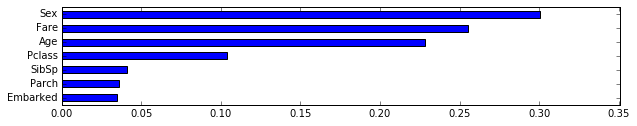

In [157]:
RandomForestTools.graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)

In [159]:
X_mini = X.drop(["SibSp", "Parch",'Embarked_C', 'Embarked_Missing', 'Embarked_Q', "Embarked_S"], axis=1)
X_test_mini = X_test.drop(["SibSp", "Parch",'Embarked_C',  'Embarked_Q', "Embarked_S"], axis=1)


In [160]:
model.fit(X_mini, y)
print("AUC: ", roc_auc_score(y, model.oob_prediction_))

AUC:  0.860258950351


So by dropping a lot of "not as important" variables, we get a model that's doing better in our AUC analysis (though only slightly).

For reference, when I run this with missing ages being set to the mean, I get 0.855. This gets a bit better when I instead set the missing ages to a bad (-100.0) value. Trying to see if missing an age note means anything.  What happens if we ignore that data altogether?

Dropping ages all togther results in 0.848, markedly worse.

### Optimize some parameters:

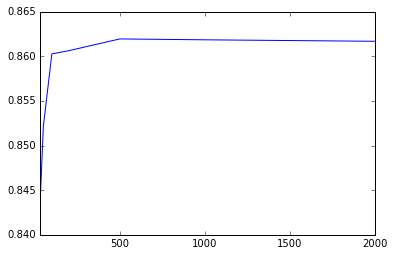

In [161]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=69)
    model.fit(X_mini, y)
    roc = roc_auc_score(y, model.oob_prediction_)
    results.append(roc)

pd.Series(results, n_estimator_options).plot();

This seems to hit the plateau around 500, so we'll keep that there.

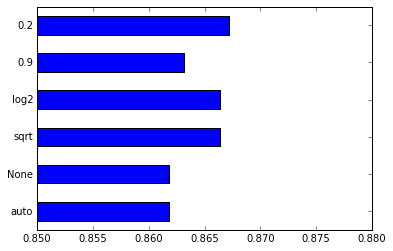

In [162]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, 
                                  random_state=69, max_features=max_features)
    model.fit(X_mini, y)
    roc = roc_auc_score(y, model.oob_prediction_)
    results.append(roc)

pd.Series(results, max_features_options).plot(kind='barh', xlim=(0.85, 0.88))

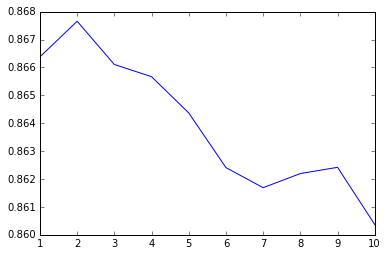

In [163]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=69, 
                                  max_features="sqrt", 
                                  min_samples_leaf=min_samples)
    model.fit(X_mini, y)
    roc = roc_auc_score(y, model.oob_prediction_)
    results.append(roc)

pd.Series(results, min_samples_leaf_options).plot();

Looks like we do the best around 2!

## Final Model with this iteration:

In [164]:
final_model = RandomForestRegressor(n_estimators=1000,
                                   oob_score=True, 
                                   n_jobs=-1,
                                   random_state=69, 
                                   max_features='sqrt',
                                   min_samples_leaf=2)
final_model.fit(X_mini, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=69,
           verbose=0, warm_start=False)

In [165]:
print("AUC: ", roc_auc_score(y, final_model.oob_prediction_))

AUC:  0.867654107947


In [179]:
output = test_passId
output = pd.DataFrame(output)
predict = pd.DataFrame(final_model.predict(X_test_mini) > 0.5)
output = output.join(predict.astype(int))
output.columns = ["PassengerId", "Survived"]
output.to_csv("RFReg_output.csv", index=False)

I submitted this model but didn't do so hot (#2800 or so in rankings)